In [94]:
# Imports
%matplotlib inline
import os
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import scipy.signal
from collections import defaultdict

In [95]:
# SID
from time import perf_counter

class SID:
    """
    Implements Spacing-Increasing Discretization as described in the DORN paper.

    Discretizes the region [alpha, beta]
    Offset controls spacing even further by discretizing [alpha + offset, beta + offset] and then
    subtracting offset from all bin edges.

    Bonus: Includes support for when the index is -1 (in which case the value should be alpha)
    and when it is sid_bins (in which case the value should be beta).

    Works in numpy.
    """
    def __init__(self, sid_bins, alpha, beta, offset):
        self.sid_bins = sid_bins
        self.alpha = alpha
        self.beta = beta
        self.offset = offset

        # Derived quantities
        self.alpha_star = self.alpha + offset
        self.beta_star = self.beta + offset
        bin_edges = np.array(range(sid_bins + 1)).astype(np.float32)
        self.sid_bin_edges = np.array(np.exp(np.log(self.alpha_star) +
                                             bin_edges / self.sid_bins * np.log(self.beta_star / self.alpha_star)))
        self.sid_bin_values = (self.sid_bin_edges[:-1] + self.sid_bin_edges[1:]) / 2 - self.offset
        self.sid_bin_values = np.append(self.sid_bin_values, [self.alpha, self.beta])
        # Do the above so that:
        # self.sid_bin_values[-1] = self.alpha < self.sid_bin_values[0]
        # and
        # self.sid_bin_values[sid_bins] = self.beta > self.sid_bin_values[sid_bins-1]

    def get_sid_index_from_value(self, arr):
        """
        Given an array of values in the range [alpha, beta], return the
        indices of the bins they correspond to
        :param arr: The array to turn into indices.
        :return: The array of indices.
        """
        sid_index = np.floor(self.sid_bins * (np.log(arr + self.offset) - np.log(self.alpha_star)) /
                                             (np.log(self.beta_star) - np.log(self.alpha_star))).astype(np.int32)
        sid_index = np.clip(sid_index, a_min=-1, a_max=self.sid_bins)
        # An index of -1 indicates alpha, while self.sid_bins indicates beta
        return sid_index

    def get_value_from_sid_index(self, sid_index):
        """
        Given an array of indices in the range {-1, 0,...,sid_bins},
        return the representative value of the selected bin.
        :param sid_index: The array of indices.
        :return: The array of values correspondding to those indices
        """
        return np.take(self.sid_bin_values, sid_index)

    def __repr__(self):
        return repr((self.sid_bins, self.alpha, self.beta, self.offset))



In [96]:
# Weighted Histogram Matching
# %load weighted_histogram_matching.py
import numpy as np

def find_movement(hist_from, hist_to):
    """Gives the movements from hist_from (column sum)
    to hist_to (row sum).

    Based on Morovic et. al 2002 A fast, non-iterative, and exact histogram matching algorithm.

    hist_from and hist_to should sum to the same value
    """
    movement = np.zeros((len(hist_from), len(hist_to)))
    for row in range(len(hist_from)):
        for col in range(len(hist_to)):
            pixels_rem = hist_from[row] - np.sum(movement[row, :col])
            pixels_req = hist_to[col] - np.sum(movement[:row, col])
            # if np.minimum(pixels_rem, pixels_req) < 0:
            #     print(row, col)
            #     print(hist_from[row])
            #     print(hist_to[col])
            #     print(pixels_rem, pixels_req)
            #     raise Exception()
            movement[row, col] = np.clip(np.minimum(pixels_rem, pixels_req), a_min=0., a_max=None)
    return movement


def move_pixels(T, init_index, weights):
    assert init_index.shape == weights.shape
    pred_index = np.zeros_like(init_index)
    cpfs = np.cumsum(T, axis=1)
    for row in range(init_index.shape[0]):
        for col in range(init_index.shape[1]):
            i = init_index[row, col]
            cpf = cpfs[i]
            p = np.random.uniform(0, cpf[-1])
            for j in range(len(cpf)):
                if cpf[j] >= p:
                    pred_index[row, col] = j
                    if T[i,j] > weights[row, col]:
                        # Leave some small positive mass here so that future pixels don't clip to 0.
                        T[i, j] = T[i, j] - weights[row, col]
                    break
    return pred_index


def move_pixels_vectorized(T, init_index, weights):
    assert init_index.shape == weights.shape
    pred_index = np.zeros_like(init_index)
    cpfs = np.cumsum(T, axis=1)  # Sum across columns
    pixel_cpfs = cpfs[init_index, :]  # Per-pixel cpf, cpf goes along axis 2
    p = np.random.uniform(0., pixel_cpfs[..., -1], size=init_index.shape)  # Generate 1 random number for each pixel
    # Use argmax trick to get first index k where p[i,j] < pixel_cpfs[i,j,k] for all i,j
    pred_index = (np.expand_dims(p, 2) < pixel_cpfs).argmax(axis=2)
    return pred_index


def move_pixels_raster(T_count, init_index, weights):
    assert init_index.shape == weights.shape
    marginal_nonzero = np.nonzero(np.sum(T_count, axis=1))[0]
    pred_index = np.zeros_like(init_index)
    index_sets = [np.where(init_index == bin_index) for bin_index in range(T_count.shape[1])]
    for old_bin in marginal_nonzero:  # Indexes rows
        possible_bins = np.nonzero(T_count[old_bin, :])[0]
        curr = 0  # Indexes current pixel
        rows, cols = index_sets[old_bin]
        for new_bin in possible_bins[:-1]:  # Indexes columns
            weight_to_move = T_count[old_bin, new_bin]
            weight_moved = 0.
            while weight_moved < weight_to_move and curr < len(rows):
                pred_index[rows[curr], cols[curr]] = new_bin
                weight_moved += weights[rows[curr], cols[curr]]
                curr += 1
        while curr < len(rows):
            pred_index[rows[curr], cols[curr]] = possible_bins[-1]
            curr += 1
    return pred_index


def image_histogram_match(init, gt_hist, weights, sid_obj):
    weights = weights * (np.sum(gt_hist) / np.sum(weights))
    init_index = np.clip(sid_obj.get_sid_index_from_value(init), a_min=0, a_max=sid_obj.sid_bins - 1)
    init_hist, _ = np.histogram(init_index, weights=weights, bins=range(sid_obj.sid_bins + 1))
    if (gt_hist < 0).any():
        print("Negative values in gt_hist")
        raise Exception()
    T_count = find_movement(init_hist, gt_hist)
#     pred_index = move_pixels_raster(T_count, init_index, weights)
#     pred_index = move_pixels(T_count, init_index, weights)
#     pred_index = move_pixels_better(T_count, init_index, weights)
    pred_index = move_pixels_vectorized(T_count, init_index, weights)
    pred = sid_obj.get_value_from_sid_index(pred_index)
    pred_hist, _ = np.histogram(pred_index, weights=weights, bins=range(len(gt_hist) + 1))
    return pred, (init_index, init_hist, pred_index, pred_hist, T_count)


def image_histogram_match_lin(init, gt_hist, weights, min_depth, max_depth):
    weights = weights * (np.sum(gt_hist) / np.sum(weights))
    n_bins = len(gt_hist)
    bin_edges = np.linspace(min_depth, max_depth, n_bins + 1)
    bin_values = (bin_edges[1:] + bin_edges[:-1])/2
    init_index = np.clip(np.floor((init - min_depth)*n_bins/(max_depth - min_depth)).astype('int'),
                         a_min=0., a_max=n_bins-1).astype('int')
    init_hist, _ = np.histogram(init_index, weights=weights, bins=range(n_bins+1))
    if (gt_hist < 0).any():
        print("Negative values in gt_hist")
        raise Exception()
    T_count = find_movement(init_hist, gt_hist)
    pred_index = move_pixels_vectorized(T_count, init_index, weights)
    pred = np.take(bin_values, pred_index)
    pred_hist, _ = np.histogram(pred_index, weights=weights, bins=range(n_bins+1))
    return pred, (init_index, init_hist, pred_index, pred_hist, T_count)


def image_histogram_match_noisy(init, gt_hist, weights, sid_obj, min_depth, max_depth, ambient_level):
    assert len(init.shape) == 2
    H, W = init.shape
    weights = weights * (np.sum(gt_hist) / np.sum(weights))
    ###
    dummy_image = np.zeros((H, 3*W))
    depth_range = np.linspace(np.min(sid_obj.sid_bin_values), max_depth, 3*W)
    for i in range(len(depth_range)):
        dummy_image[:, i] = depth_range[i]
    dummy_weights = np.ones_like(dummy_image) * ambient_level/np.sum(depth_range)
    init = np.hstack((init, dummy_image))
    weights = np.hstack((weights, dummy_weights))
    ###
    init_index = np.clip(sid_obj.get_sid_index_from_value(init), a_min=0, a_max=sid_obj.sid_bins - 1)
    init_hist, _ = np.histogram(init_index, weights=weights, bins=range(sid_obj.sid_bins + 1))
    plt.figure()
    plt.bar(range(len(init_hist)), init_hist, log=True)
    if (gt_hist < 0).any():
        print("Negative values in gt_hist")
        raise Exception()
    T_count = find_movement(init_hist, gt_hist)
#     pred_index = move_pixels_raster(T_count, init_index, weights)
#     pred_index = move_pixels(T_count, init_index, weights)
#     pred_index = move_pixels_better(T_count, init_index, weights)
    pred_index = move_pixels_vectorized(T_count, init_index, weights)[:, :W]
    pred = sid_obj.get_value_from_sid_index(pred_index)
    pred_hist, _ = np.histogram(pred_index, weights=weights[:,:W], bins=range(len(gt_hist) + 1))
    return pred, (init_index, init_hist, pred_index, pred_hist, T_count)

def summarize_in_subplot(axs, col, img, hist, gt, title):
    axs[0, col].set_title(title, fontsize=24)
    axs[0, col].imshow(img, vmin=0., vmax=10.)
    axs[0, col].axis('off')
    axs[1, col].bar(range(len(hist)), hist)
    rmse = np.sqrt(np.mean((gt - img) ** 2))
    axs[1, col].set_xlabel("RMSE = {:1.3f}".format(rmse), fontsize=24)


In [97]:
# %%writefile spad_utils.py
import numpy as np
from scipy.signal import fftconvolve
import cvxpy as cp

def simulate_spad(depth_truth, intensity, mask, min_depth, max_depth,
                  spad_bins, photon_count, dc_count, fwhm_ps,
                  use_poisson, use_intensity, use_squared_falloff,
                  use_jitter):
    """
    Works in numpy.
    :param depth_truth: The ground truth depth map (z, not distance...)
    :param albedo: The albedo map, aligned with the ground truth depth map.
    :param mask: The mask of valid pixels
    :param min_depth: The minimum depth value (used for the discretization).
    :param max_depth: The maximum depth value (used for the discretization).
    :param spad_bins: The number of spad bins to simulate
    :param photon_count: The number of photons to collect
    :param dc_count: The additional fraction of photons to add to account for dark count + ambient light
    :param fwhm_ps: The full-width-at-half-maximum of the laser pulse jitter
    :param use_poisson: Whether or not to apply poisson noise at the end.
    :param use_intensity: Whether or not to take an intensity image into account when simulating.
    :param use_squared_falloff: Whether or not to take the squared depth into account when simulating
    :return: A simulated spad.
    """
    weights = mask
    if use_intensity:
        weights = weights * intensity
    if use_squared_falloff:
        weights = weights / (depth_truth ** 2 + 1e-6)
    # Note: bins being 1D overrides the use of range
    depth_hist, _ = np.histogram(depth_truth, bins=spad_bins, range=(min_depth, max_depth), weights=weights)

    # Scale by number of photons
    spad_counts = depth_hist * (photon_count / np.sum(depth_hist))

    # Add ambient/dark counts (dc_count) w/ Gaussian noise
    spad_counts += np.ones(len(spad_counts)) * (dc_count / spad_bins) #+ 0.01*np.random.randn(len(spad_counts))

    # Convolve with PSF
    if use_jitter:
        bin_width_m = float(max_depth - min_depth) / spad_bins  # meters/bin
        bin_width_ps = 2 * bin_width_m * 1e12 / (3e8)   # ps/bin, speed of light = 3e8, x2 because light needs to travel there and back.
        fwhm_bin = fwhm_ps / bin_width_ps
        psf = makeGaussianPSF(len(spad_counts), fwhm=fwhm_bin)
        spad_counts = fftconvolve(psf, spad_counts)[:int(spad_bins)]
        spad_counts = np.clip(spad_counts, a_min=0., a_max=None)

    if use_poisson:
        spad_counts = np.random.poisson(spad_counts)
    return spad_counts


def simulate_spad_sid(depth, intensity, mask, min_depth, max_depth,
                      sid_obj, spad_bins, photon_count, dc_count, fwhm_ps,
                      use_poisson, use_intensity, use_squared_falloff,
                      use_jitter):
    spad = simulate_spad(depth, intensity, mask, min_depth, max_depth,
                                spad_bins, photon_count, dc_count, fwhm_ps,
                                use_poisson, use_intensity, use_squared_falloff,
                                use_jitter)
    spad_sid = rescale_bins(spad, min_depth, max_depth, sid_obj)
    return spad_sid


def makeGaussianPSF(size, fwhm=3):
    """ Make a gaussian kernel.
    size is the length of the array
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    x0 = size // 2
    return np.roll(np.exp(-4 * np.log(2) * ((x - x0) ** 2) / fwhm ** 2), len(x) - x0)


def rescale_bins(spad_counts, min_depth, max_depth, sid_obj):
    """
    Works in Numpy
    :param spad_counts: The histogram of spad counts to rescale.
    :param min_depth: The minimum depth of the histogram.
    :param max_depth: The maximum depth of the histogram.
    :param sid_obj: An object representing a SID.
    :return: A rescaled histogram in time to be according to the SID

    Assign photons to sid bins proportionally according to the amount of overlap between
    the sid bin range and the spad_count bin.
    """

    sid_bin_edges_m = sid_obj.sid_bin_edges

    # Convert sid_bin_edges_m into units of spad bins
    sid_bin_edges_bin = sid_bin_edges_m * len(spad_counts) / (max_depth - min_depth)

    # Map spad_counts onto sid_bin indices
    sid_counts = np.zeros(sid_obj.sid_bins)
    for i in range(sid_obj.sid_bins):
        left = sid_bin_edges_bin[i]
        right = sid_bin_edges_bin[i + 1]
        curr = left
        while curr != right:
            curr = np.min([right, np.floor(left + 1.)])  # Don't go across spad bins - stop at integers
            sid_counts[i] += (curr - left) * spad_counts[int(np.floor(left))]
            # Update window
            left = curr
    return sid_counts


from collections import OrderedDict
spad_types = OrderedDict([
    ("rawhist", {#Rawhist
        "spad_bins": 1024,
        "photon_count": 1e6,
        "dc_count": 0.,
        "fwhm_ps": 70.,
        "use_poisson": False,
        "use_intensity": False,
        "use_squared_falloff": False,
        "use_jitter": False
    }),
    ("intensity", {#Intensity
        "spad_bins": 1024,
        "photon_count": 1e6,
        "dc_count": 0.,
        "fwhm_ps": 70.,
        "use_poisson": False,
        "use_intensity": True,
        "use_squared_falloff": False,
        "use_jitter": False
    }),
    ("intensity + falloff", {#Intensity + falloff
        "spad_bins": 1024,
        "photon_count": 1e6,
        "dc_count": 0.,
        "fwhm_ps": 70.,
        "use_poisson": False,
        "use_intensity": True,
        "use_squared_falloff": True,
        "use_jitter": False
    }),
    ("intensity + falloff + dc", {#Intensity+falloff+dc
        "spad_bins": 1024,
        "photon_count": 1e6,
        "dc_count": 1e5,
        "fwhm_ps": 70.,
        "use_poisson": False,
        "use_intensity": True,
        "use_squared_falloff": True,
        "use_jitter": False
    }),
    ("intensity + falloff + dc + jitter", {#Intensity+falloff+dc+jitter
        "spad_bins": 1024,
        "photon_count": 1e6,
        "dc_count": 1e5,
        "fwhm_ps": 70.,
        "use_poisson": False,
        "use_intensity": True,
        "use_squared_falloff": True,
        "use_jitter": True
    }),
    ("intensity + falloff + dc + jitter + poisson", {#Intensity+falloff+dc+jitter+poisson
        "spad_bins": 1024,
        "photon_count": 1e6,
        "dc_count": 1e5,
        "fwhm_ps": 70.,
        "use_poisson": True,
        "use_intensity": True,
        "use_squared_falloff": True,
        "use_jitter": True
    }),
    ("intensity + falloff + dc + poisson", {#Intensity+falloff+dc+poisson
        "spad_bins": 1024, 
        "photon_count": 1e6,
        "dc_count": 1e5,
        "fwhm_ps": 70.,
        "use_poisson": True,
        "use_intensity": True,
        "use_squared_falloff": True,
        "use_jitter": False
    }),
        ("intensity + falloff + dc + poisson (SBR=50)", {#Intensity+falloff+dc+poisson
        "spad_bins": 1024, 
        "photon_count": 1e6,
        "dc_count": 2e4,
        "fwhm_ps": 70.,
        "use_poisson": True,
        "use_intensity": True,
        "use_squared_falloff": True,
        "use_jitter": False
    }),
    ("intensity + falloff + dc + poisson (SBR=100)", {#Intensity+falloff+dc+poisson
        "spad_bins": 1024, 
        "photon_count": 1e6,
        "dc_count": 1e4,
        "fwhm_ps": 70.,
        "use_poisson": True,
        "use_intensity": True,
        "use_squared_falloff": True,
        "use_jitter": False
    })
])


In [98]:
# Load Data, Set Global Parameters, Save to matlab
import scipy.io as sio
inits = np.load("data/densedepth_test_outputs.npy")
rgb = np.load("data/nyu_depth_v2_labeled_numpy/test_images_cropped.npy")
depths = np.load("data/nyu_depth_v2_labeled_numpy/test_depths_cropped.npy")

spad_types_of_interest = [
    ("intensity", spad_types["intensity"]),
#     ("intensity + falloff", spad_types["intensity + falloff"]),
    ("intensity + falloff + dc", spad_types["intensity + falloff + dc"]),
    ("intensity + falloff + dc + poisson", spad_types["intensity + falloff + dc + poisson"]),
    ("intensity + falloff + dc + poisson (SBR=50)", spad_types["intensity + falloff + dc + poisson (SBR=50)"]),
    ("intensity + falloff + dc + poisson (SBR=100)", spad_types["intensity + falloff + dc + poisson (SBR=100)"]),
]

def load_spad_from_dict(dataset_type, spad_config):
    hyper_string = "{}_int_{}_fall_{}_dc_{}_jit_{}_poiss_{}".format(
        dataset_type,
        spad_config["use_intensity"],
        spad_config["use_squared_falloff"],
        spad_config["dc_count"],
        spad_config["use_jitter"],
        spad_config["use_poisson"])
    spad_file = os.path.join("data", "{}_spad.npy".format(hyper_string))
    print("Loading data from {}".format(spad_file))
    spad_dict = np.load(spad_file, allow_pickle=True).item()
    spad_data = spad_dict["spad"]
    intensity_data = spad_dict["intensity"]
    spad_config = spad_dict["config"]
    return spad_data, intensity_data, spad_config

spad_data_of_interest = {}
dataset_type = "test"
for title, config in spad_types_of_interest:
    spad_data_of_interest[title] = load_spad_from_dict(dataset_type, config)
    # Save to matlab
    hyper_string = "{}_int_{}_fall_{}_dc_{}_jit_{}_poiss_{}_spad".format(
        dataset_type,
        config["use_intensity"],
        config["use_squared_falloff"],
        config["dc_count"],
        config["use_jitter"],
        config["use_poisson"])
    # Raw Counts
    spad_data = spad_data_of_interest[title][0]
    matdict = {"data": spad_data}
    print("Saving to matlab/{}.mat".format(hyper_string))
    sio.savemat("matlab/{}.mat".format(hyper_string), matdict)
    # Rescaled Counts
    spad_rescaled = np.zeros((spad_data.shape[0], sid_obj.sid_bins))
    for i in range(spad_data.shape[0]):
        spad_rescaled[i,...] = rescale_bins(spad_data[i,...], min_depth, max_depth, sid_obj)
        bin_widths = sid_obj.sid_bin_edges[1:] - sid_obj.sid_bin_edges[:-1]
        spad_rescaled[i,...] = spad_rescaled[i,...] / bin_widths
    matdict = {"data": spad_rescaled}
    print("Saving to matlab/{}_sid.mat".format(hyper_string))
    sio.savemat("matlab/{}_sid.mat".format(hyper_string), matdict)
    

Loading data from data/test_int_True_fall_False_dc_0.0_jit_False_poiss_False_spad.npy
Saving to matlab/test_int_True_fall_False_dc_0.0_jit_False_poiss_False_spad.mat
Saving to matlab/test_int_True_fall_False_dc_0.0_jit_False_poiss_False_spad_sid.mat
Loading data from data/test_int_True_fall_True_dc_100000.0_jit_False_poiss_False_spad.npy
Saving to matlab/test_int_True_fall_True_dc_100000.0_jit_False_poiss_False_spad.mat
Saving to matlab/test_int_True_fall_True_dc_100000.0_jit_False_poiss_False_spad_sid.mat
Loading data from data/test_int_True_fall_True_dc_100000.0_jit_False_poiss_True_spad.npy
Saving to matlab/test_int_True_fall_True_dc_100000.0_jit_False_poiss_True_spad.mat
Saving to matlab/test_int_True_fall_True_dc_100000.0_jit_False_poiss_True_spad_sid.mat
Loading data from data/test_int_True_fall_True_dc_20000.0_jit_False_poiss_True_spad.npy
Saving to matlab/test_int_True_fall_True_dc_20000.0_jit_False_poiss_True_spad.mat
Saving to matlab/test_int_True_fall_True_dc_20000.0_jit_Fal

In [99]:
# Load from matlab (and save back to python)
import scipy.io as sio
level = 6
method = "Bayes"
for title, config in spad_types_of_interest:
    if config["dc_count"] <= 0. or not config["use_poisson"]:
        continue
    hyper_string = "{}_int_{}_fall_{}_dc_{}_jit_{}_poiss_{}_spad_denoised_{}_{}".format(
        dataset_type,
        config["use_intensity"],
        config["use_squared_falloff"],
        config["dc_count"],
        config["use_jitter"],
        config["use_poisson"],
        level,
        method)
    matdict = {"data": spad_data_of_interest[title][0]}
    data = sio.loadmat("matlab/{}.mat".format(hyper_string))
    spad_denoised = data["spad_denoised"]
    spad_data_of_interest[title] = (spad_denoised, spad_data_of_interest[title][1],
                                    spad_data_of_interest[title][2])
    out_dict = {
        "spad": spad_denoised,
        "intensity": spad_data_of_interest[title][1],
        "config": spad_data_of_interest[title][2]
    }
    np.save(os.path.join("data", "{}.npy".format(hyper_string)), out_dict)
#     plt.figure()
#     i = 2
#     plt.bar(range(len(spad_denoised[i,:])), spad_denoised[i,:], log=True)

In [ ]:
# Variance Regularization
### %%writefile remove_dc_from_spad.py
import cvxpy as cp
import numpy as np

def remove_dc_from_spad_var_reg(noisy_spad, bin_edges, bin_weight, bin_depths, gt_var, lam1=1e-2, lam2=1e-2
                                eps_rel=1e-5):
    """
    Works in numpy.
    :param noisy_spad: Length C array with the raw spad histogram to denoise.
    :param bin_edges: Length C+1 array with the bin widths in meters of the original bins.
    :param bin_weight: Length C nonnegative array controlling relative strength of L1 regularization on each bin.
    :param lam: float value controlling strength of overall L1 regularization on the signal
    :param eps: float value controlling precision of solver
    """
    assert len(noisy_spad.shape) == 1
    C = noisy_spad.shape[0]
    assert bin_edges.shape == (C+1,)
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    spad_equalized = noisy_spad / bin_widths
    x = cp.Variable((C,), "signal")
    z = cp.Variable((1,), "noise")
    x_var = (bin_depths**2)*x/cp.sum(x) - (bin_depths*x/cp.sum(x))**2
    obj = cp.Minimize(cp.sum_squares(spad_equalized - (x + z))
                      + lam1 * cp.sum(bin_weight*cp.abs(x)))
                      + lam2 * (x_var - gt_var)
    constr = [
        x >= 0,
        z >= 0
    ]
    prob = cp.Problem(obj, constr)
    prob.solve(solver=cp.OSQP, eps_rel=eps_rel)
    denoised_spad = np.clip(x.value * bin_widths, a_min=0., a_max=None)
    return denoised_spad


def preprocess_spad_sid(spad_sid, sid_obj, correct_falloff, remove_dc, **kwargs):
    if remove_dc:
        spad_sid = remove_dc_from_spad(spad_sid,
                                       sid_obj.sid_bin_edges,
                                       sid_obj.sid_bin_values[:-2]**2,
                                       lam=kwargs["lam"],
                                       eps_rel=kwargs["eps_rel"])
    if correct_falloff:
        spad_sid = spad_sid * sid_obj.sid_bin_values[:-2]**2
    return spad_sid


def preprocess_spad(spad, min_depth, max_depth, correct_falloff, remove_dc, **sid_kwargs):
    if remove_dc:
        spad = remove_dc_from_spad(spad,
                                   np.array(range(len(spad) + 1)).astype('float'),
                                   np.linspace(min_depth, max_depth, len(spad))**2+1e-4,
                                   lam=sid_kwargs["lam"],
                                   eps_rel=sid_kwargs["eps_rel"])
    if correct_falloff:
        spad = spad * (np.linspace(min_depth, max_depth, len(spad)))**2
    return spad

In [ ]:
# Testing
def remove_dc_from_spad_test(noisy_spad, bin_edges, bin_weight,
                                 use_anscombe, use_quad_over_lin,
                                 use_poisson, use_squared_falloff,
                                 lam1=1e-2, lam2=1e-1, eps_rel=1e-5):
    def anscombe(x):
        return 2*np.sqrt(x + 3./8)
    def inv_anscombe(x):
        return (x/2)**2 - 3./8
    assert len(noisy_spad.shape) == 1
    C = noisy_spad.shape[0]
    
    assert bin_edges.shape == (C+1,)
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    spad_equalized = noisy_spad / bin_widths
    x = cp.Variable((C,), "signal")
    z = cp.Variable((1,), "dc")
    nx = cp.Variable((C,), "signal noise")
    nz = cp.Variable((C,), "dc noise")
    if use_poisson:
        # Need tricky stuff
        if use_anscombe:
#             plt.figure()
#             plt.bar(range(len(spad_equalized)), spad_equalized, log=True)
#             plt.title("Before")
    #         d_ans = cp.Variable((C,), "denoised anscombe")
            # Apply Anscombe Transform to data:
            spad_ans = anscombe(spad_equalized)
            # Apply median filter to remove Gaussian Noise
            spad_ans_filt = scipy.signal.medfilt(spad_ans, kernel_size=15)
            # Apply Inverse Anscombe Transform
            spad_equalized = inv_anscombe(spad_ans_filt)
#             plt.figure()
#             plt.bar(range(len(spad_equalized)), spad_equalized, log=True)
#             plt.title("After")

        if use_quad_over_lin:
            obj = \
                    cp.sum([cp.quad_over_lin(nx[i], x[i]) for i in range(C)]) + \
                    cp.sum([cp.quad_over_lin(nz[i], z) for i in range(C)]) + \
                    lam2 * cp.sum(bin_weight*cp.abs(x))
            constr = [
                x >= 0,
                x + nx >= 0,
                z >= cp.min(spad_equalized),
                z + nz >= cp.min(spad_equalized),
                x + nx + z + nz == spad_equalized
            ]
            prob = cp.Problem(cp.Minimize(obj), constr)
            prob.solve(solver=cp.ECOS, verbose=True, reltol=eps_rel)
        else:
            obj = cp.sum_squares(spad_equalized - (x + z)) + lam2 * cp.sum(bin_weight*cp.abs(x))
            constr = [
                x >= 0,
                z >= 0
            ]
            prob = cp.Problem(cp.Minimize(obj), constr)
            prob.solve(solver=cp.OSQP, verbose=True, eps_rel=eps_rel)
    else:
        # No need for tricky stuff
        obj = cp.sum_squares(spad_equalized - (x + z)) + 1e0 * cp.sum(bin_weight*cp.abs(x))
        constr = [
            x >= 0,
            z >= 0
        ]
        prob = cp.Problem(cp.Minimize(obj), constr)
        prob.solve(solver=cp.OSQP, eps_rel=eps_rel)
    denoised_spad = np.clip(x.value * bin_widths, a_min=0., a_max=None)
    print("z.value", z.value)
    return denoised_spad



In [100]:
# Plotting
def plot_gt_comparison(ax_init, ax_truth, depth_init, depth_truth,
                       min_depth, max_depth, fontsize):
    ax_init.imshow(depth_init, vmin=min_depth, vmax=max_depth)
    ax_init.set_title("Depth Init")
    ax_truth.imshow(depth_truth, vmin=min_depth, vmax=max_depth)
    ax_truth.set_title("Ground Truth")
    ax_init.set_xlabel("RMSE = {}".format(np.sqrt(np.mean((depth_init-depth_truth)**2))), fontsize=fontsize)



In [21]:
def remove_dc_from_spad_poisson_analytic(noisy_spad, bin_edges, ambient_estimate, lam=1e0, axs=None):
    assert len(noisy_spad.shape) == 1
    C = noisy_spad.shape[0]
    assert bin_edges.shape == (C+1,)
    bin_widths = bin_edges[1:] - bin_edges[:-1]
#     spad_equalized = noisy_spad / bin_widths
#     ambient_equalized = ambient_estimate / bin_widths
#     spad_equalized = anscombe(spad_equalized)
#     spad_equalized = scipy.signal.medfilt(spad_equalized, kernel_size=13)
#     spad_equalized = inv_anscombe(spad_equalized)
#     orig_sum = np.sum(spad_equalized)
#     spad_normalized = spad_equalized/orig_sum
    d = ambient_estimate
    rho = 2*lam
    h = noisy_spad
    signal = -(1 + rho*d)/(2*rho) + \
        np.sqrt(((1 + rho*d)/(2*rho))**2 + (h - d)/rho)
    if axs is not None:
        low = 1e-2
        high = 1e6
        axs[0].bar(range(len(noisy_spad)), noisy_spad, log=True)
        axs[0].set_title("SPAD Normalized")
        axs[0].axhline(y=d, color='r', linewidth=0.5)
        axs[0].set_ylim(low, high)
        axs[1].bar(range(len(signal)), signal, log=True)
        axs[1].set_ylim(low, high)
    signal = np.clip(signal, a_min=0., a_max=None)
    return signal

In [21]:
# Original
### %%writefile remove_dc_from_spad.py
import cvxpy as cp
import numpy as np

def remove_dc_from_spad(noisy_spad, bin_edges, bin_weight, lam=1e-2, eps_rel=1e-5):
    """
    Works in numpy.
    :param noisy_spad: Length C array with the raw spad histogram to denoise.
    :param bin_edges: Length C+1 array with the bin widths in meters of the original bins.
    :param bin_weight: Length C nonnegative array controlling relative strength of L1 regularization on each bin.
    :param lam: float value controlling strength of overall L1 regularization on the signal
    :param eps: float value controlling precision of solver
    """
    assert len(noisy_spad.shape) == 1
    C = noisy_spad.shape[0]
    assert bin_edges.shape == (C+1,)
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    spad_equalized = noisy_spad / bin_widths
#     print("spad_equalized", spad_equalized)
#     print("lam", lam)
#     print("eps_rel", eps_rel)
    x = cp.Variable((C,), "signal")
    z = cp.Variable((1,), "noise")
    obj = cp.Minimize(cp.sum_squares(spad_equalized - (x + z)) + lam * cp.sum(bin_weight*cp.abs(x)))
    constr = [
        x >= 0,
#         z >= 0
    ]
#     print("lam = {}".format(lam))
    prob = cp.Problem(obj, constr)
    prob.solve(solver=cp.OSQP, eps_rel=eps_rel)
#     print("x.value = {}".format(x.value))
#     print("z.value", z.value)
    denoised_spad = np.clip(x.value * bin_widths, a_min=0., a_max=None)
    return denoised_spad


In [9]:
# Poisson Denoising
import cvxpy as cp
import numpy as np

def anscombe(x):
    return 2*np.sqrt(x + 3./8)
def inv_anscombe(x):
    return (x/2)**2 - 3./8

def remove_dc_from_spad_poisson(noisy_spad, bin_edges, bin_weight,
                                lam, axs=None):
    assert len(noisy_spad.shape) == 1
    C = noisy_spad.shape[0]
    assert bin_edges.shape == (C+1,)
    assert bin_weight.shape == (C,)
    bin_weight = bin_weight/np.sum(bin_weight)
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    spad_equalized = noisy_spad / bin_widths
#     spad_equalized = anscombe(spad_equalized)
#     spad_equalized = scipy.signal.medfilt(spad_equalized, kernel_size=13)
#     spad_equalized = inv_anscombe(spad_equalized)
    orig_sum = np.sum(spad_equalized)
    spad_normalized = spad_equalized/orig_sum

    x = cp.Variable((C,), "signal")
    z = cp.Variable((1,), "dc")
    obj = -spad_normalized*cp.log(z + x) + cp.sum(z + x) + \
            + lam*cp.sum_squares(x)
#           + lam*cp.norm(x,2)

#           lam*cp.sum_squares(cp.multiply(bin_weight, x))
#          lam*cp.norm(x, 2)
          
#           lam*cp.square(cp.norm(cp.multiply(bin_weight, x), 2))
#     obj = -spad_equalized*cp.log(z + x) + cp.sum(z + x) + lam*cp.sum_squares(x)
    constr = [
        z >= 0,
        x >= 0
    ]

    prob = cp.Problem(cp.Minimize(obj), constr)
    prob.solve(verbose=False, gp=False)
#     noise = np.exp(z.value)
#     signal = np.exp(x.value)
#     print((-spad_normalized*cp.log(z+x)).value)
#     print(cp.sum_squares(x).value)
    noise = z.value
    signal = x.value
    print("z.value", z.value)
    if axs is not None:
        low = 1e-10
        high = 1e-1
        axs[0].bar(range(len(spad_normalized)), spad_normalized, log=True)
        axs[0].set_title("SPAD Normalized")
        axs[0].set_ylim(low, high)
        axs[1].bar(range(len(signal)), signal, log=True)
        axs[1].set_ylim(low, high)
#     zero_out = x.value
#     zero_out[zero_out < 1e0] = 0.
    frac = orig_sum / (np.sum(signal) + len(spad_equalized)*noise)
    denoised_spad = np.clip(frac * signal * bin_widths, a_min=0., a_max=None)
    return denoised_spad

In [116]:
# Ambient Estimate
def remove_dc_from_spad_ambient_estimate(spad, min_depth, max_depth, global_min_depth, n_std=1., axs=None):
    assert len(spad.shape) == 1
    assert global_min_depth > min_depth
    def anscombe(x):
        return 2*np.sqrt(x + 3./8)
    def inv_anscombe(x):
        return (x/2)**2 - 3./8
    N = len(spad)
    # Estimate ambient level from first few bins of spad
    t = (global_min_depth - min_depth)/(max_depth - min_depth)
    M = np.mean(spad[:int(np.floor(t*N))])
#     print(M)
#     spad = anscombe(spad)
#     spad = scipy.signal.medfilt(spad, kernel_size=5)
#     spad = inv_anscombe(spad)
    cutoff = M + n_std*np.sqrt(M)
    spad_denoised = np.clip((spad - cutoff), a_min=0., a_max=None)
    if axs is not None:
        axs[0].bar(range(len(spad)), spad, log=True)
        axs[0].axhline(y=cutoff, color='r', linewidth=0.5)
    return spad_denoised


In [107]:
import scipy.signal as signal
a = np.array([1, 1, 2, 3, 4]).astype('float')
out1 = np.diff(a)
print(out1)

out2 = cv2.Sobel(a.reshape(1, -1), cv2.CV_64F, 1, 0)/2
print(out2)

[0. 1. 1. 1.]
[[0. 2. 4. 4. 0.]]


In [124]:
import cv2
def sobel_edge_detection(x, thresh, ax=None):
    grad = cv2.Sobel(x, cv2.CV_64F, 1, 0)
    if ax is not None:
        ax.bar(range(len(grad.squeeze())), np.abs(grad.squeeze())/2, log=True)
        ax.axhline(y=thresh, color='r', linewidth=0.5)
    return np.abs(grad)/2 >= thresh
def diff_edge_detection(x, thresh, ax=None):
    np.abs(np.diff(x))
test = np.array([[1, 1, 1, 3, 2, 3, 1, 1, 1]]).astype('float')
out = sobel_edge_detection(test, 1)
print(np.nonzero(out))
print("first:", np.nonzero(out)[1][0])
print("last:", np.nonzero(out)[1][-1])
# print(np.argmax(sobel_edge_detection(test, 1))

def find_first_and_last_edge(x, thresh):
    edges = sobel_edge_detection(x, thresh)


import scipy.signal as spsig
def remove_dc_from_spad_edge(spad, ambient, grad_th=1e3, n_std=1.,
                             axs=None):
    """
    Create a "bounding box" that is bounded on the left and the right
    by using the gradients and below by using the ambient estimate.
    """
    # Detect edges:
    assert len(spad.shape) == 1
#     spad_2d = spad.reshape(1, -1)
#     grad_kernel = np.array([1,0,-1])
#     edges = sobel_edge_detection(spad_2d, grad_th, ax=axs[0])
    edges = np.abs(np.diff(spad)) > grad_th
    first = np.nonzero(edges)[0][1] + 1  # Want the right side of the first edge
#     print(first)
    last = np.nonzero(edges)[0][-1]      # Want the left side of the second edge
#     print(last)
    if axs is not None:
        ax = axs[0]
        ax.bar(range(len(np.abs(np.diff(spad)))), np.abs(np.diff(spad)), log=True)
        ax.axhline(y=grad_th, color='r', linewidth=0.5)
    below = ambient + n_std*np.sqrt(ambient)
    # Walk first and last backward and forward until we encounter a value below the threshold
    while first >= 0 and spad[first] > below:
        first -= 1
    while last < len(spad) and spad[last] > below:
        last += 1
    print("first", first)
    print("last", last)
    if axs is not None:
        ax = axs[1]
        ax.bar(range(len(spad)), spad, log=True)
        ax.axvline(x=first, color='r', linewidth=0.5)
        ax.axvline(x=last, color='r', linewidth=0.5)
        ax.axhline(y=below, color='r', linewidth=0.5)
        ax.set_title("SPAD with bounding lines")
    spad[:first] = 0.
    spad[last+1:] = 0.
    return np.clip(spad - ambient, a_min=0., a_max=None)
    
    

(array([0, 0, 0, 0]), array([2, 3, 5, 6]))
first: 2
last: 6


Running 0
Running intensity
	RMSE = 0.16025484987775623
Running intensity + falloff + dc
first 190
last 366
	RMSE = 0.16027615763649877
Running intensity + falloff + dc + poisson
first 189
last 366
	RMSE = 0.160188380113113
Running intensity + falloff + dc + poisson (SBR=50)
first 189
last 366
	RMSE = 0.16017628680065052
Running intensity + falloff + dc + poisson (SBR=100)
first 187
last 366
	RMSE = 0.1602541818265041
Running 1
Running intensity
	RMSE = 0.21949497131545956
Running intensity + falloff + dc
first 114
last 267
	RMSE = 0.2195340324345081
Running intensity + falloff + dc + poisson
first 114
last 268
	RMSE = 0.21957271618936397
Running intensity + falloff + dc + poisson (SBR=50)
first 114
last 268
	RMSE = 0.21962361881431577
Running intensity + falloff + dc + poisson (SBR=100)
first 114
last 269
	RMSE = 0.21928188414511485
Running 2
Running intensity
	RMSE = 0.26697246899119215
Running intensity + falloff + dc
first 101
last 704
	RMSE = 0.2687217889117717
Running intensity +

ValueError: shape mismatch: objects cannot be broadcast to a single shape

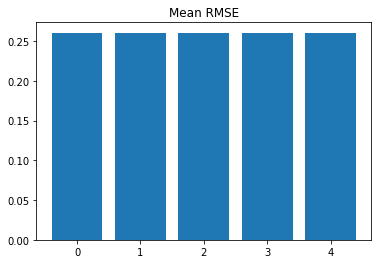

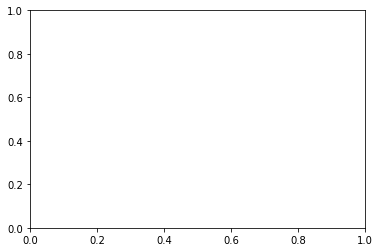

In [125]:
# Run
min_depth = 0.
max_depth = 10.
sid_obj = SID(sid_bins=140, alpha=0.6569154266167957, beta=9.972175646365525, offset=0)
sid_bin_widths = sid_obj.sid_bin_edges[1:] - sid_obj.sid_bin_edges[:-1]
fontsize = 25
plot_stuff = True
rmses = defaultdict(list)
rmses_sid = defaultdict(list)
# for i in range(val.shape[2]):
# 654 images, subsample by 
for i in range(5):
    print("Running {}".format(i))
    depth_truth = depths[..., i]
    depth_init = inits[i, 0, ...]
    
    # Plot GT Comparison
    if plot_stuff:
        fig, axs = plt.subplots(6, len(spad_types_of_interest)+1,
                                figsize=(10*(len(spad_types_of_interest)+1), 18))
        fig_sid, axs_sid = plt.subplots(6, len(spad_types_of_interest)+1,
                                figsize=(10*(len(spad_types_of_interest)+1), 18))
        plot_gt_comparison(axs[5,0], axs[4,0], depth_init, depth_truth,
                           min_depth, max_depth, fontsize)
        plot_gt_comparison(axs_sid[5,0], axs_sid[4,0], depth_init, depth_truth,
                           min_depth, max_depth, fontsize)

    for j, (title, _) in enumerate(spad_types_of_interest):
        # Retrieve spad data
        spad_data, intensity_data, spad_config = spad_data_of_interest[title]
        spad = np.clip(spad_data[i,...], a_min=0., a_max=None)
        intensity = intensity_data[i,0,...]
        print("Running {}".format(title))
        
        # Denoise, then rescale
        if True:
            if plot_stuff:
                axs[0,j+1].set_title("{}".format(title))
                axs[0,j+1].bar(range(len(spad)), spad, log=True)
                axs[0,j+1].set_ylim(1e-1, 1e5)
                axs[0,1].set_ylabel("Simulated")
            lin_bin_edges = np.linspace(min_depth, max_depth, len(spad) + 1)
            lin_bin_values = (lin_bin_edges[1:] + lin_bin_edges[:-1])/2
#             lin_bin_values = lin_bin_edges[:-1] + 1e-4
            if spad_config["dc_count"] > 0.:
                if not spad_config["use_poisson"]:
                    lam = 1e-1
                else:
                    if spad_config["dc_count"] == 1e5:
                        lam = 1e0
                    elif spad_config["dc_count"] == 2e4:
                        lam = 9e-1
                    elif spad_config["dc_count"] == 1e4:
                        lam = 8e-1
                    else:
                        raise ValueError("dc_count = {}".format(dc_count))
#                 spad = remove_dc_from_spad(spad,
#                                            lin_bin_edges,
#                                            lin_bin_values**2,
#                                            lam=1e1 if spad_config["use_poisson"] else 1e-1,
#                                            eps_rel=1e-5)
#                 spad = remove_dc_from_spad_poisson_analytic(spad,
#                                                             lin_bin_edges,
#                                                             ambient_estimate=spad_config["dc_count"]/len(spad),
#                                                             lam=lam,
#                                                             axs=axs[1:3, j+1])
                ambient = spad_config["dc_count"]/len(spad)
                spad = remove_dc_from_spad_edge(spad,
                                                 ambient=ambient,
                                                 grad_th=2*ambient,
                                                 axs=axs[1:3,j+1])
#                 print(spad[:10])
            if spad_config["use_squared_falloff"]:
                spad = spad * lin_bin_values**2
            if plot_stuff:
                axs[3,j+1].bar(range(len(spad)), spad, log=True)
                axs[3,j+1].set_ylim(1e-1, 1e5)
                axs[3,1].set_ylabel("Denoised");
            spad_rescaled = rescale_bins(spad, min_depth, max_depth, sid_obj)
#             pred, t = image_histogram_match_lin(depth_init,
#                                                 spad,
#                                                 weights=intensity,
#                                                 min_depth=min_depth,
#                                                 max_depth=max_depth)
            pred, t = image_histogram_match(depth_init,
                                            spad_rescaled,
                                            intensity,
                                            sid_obj)
            rmse = np.sqrt(np.mean((depth_truth-pred)**2))
            print("\tRMSE = {}".format(rmse))
            rmses[title].append(rmse)
            if plot_stuff:
                axs[5,j+1].imshow(pred, vmin=min_depth, vmax=max_depth)
                axs[5,j+1].set_xlabel("RMSE={}".format(rmse), fontsize=fontsize)

        ### Rescale, then denoise
        if False:
            spad = np.clip(spad_data[i,...], a_min=0., a_max=None)
            spad_sid = rescale_bins(spad, min_depth, max_depth, sid_obj)
#             print("spad_rescaled", spad_sid)
            if plot_stuff:
                axs_sid[0,j+1].set_title("{} (SID)".format(title))
                axs_sid[0,j+1].bar(range(len(spad_sid)), spad_sid, log=True)
                axs_sid[0,j+1].set_ylim(1e-1,1e6)
                axs_sid[0,1].set_ylabel("Simulated")
            if spad_config["dc_count"] > 0.:
                spad_sid = remove_dc_from_spad(spad_sid,
                                           sid_obj.sid_bin_edges,
                                           sid_obj.sid_bin_values[:-2]**2,
                                           lam=1e1 if spad_config["use_poisson"] else 1e-1,
                                           eps_rel=1e-5)
                if not spad_config["use_poisson"]:
                    lam = 1e-1
                else:
                    if spad_config["dc_count"] == 1e5:
                        lam = 1e1
                    elif spad_config["dc_count"] == 2e4:
                        lam = 1e1
                    elif spad_config["dc_count"] == 1e4:
                        lam = 1e1
                    else:
                        raise ValueError("dc_count = {}".format(dc_count))
                    
#                 spad_sid = remove_dc_from_spad_poisson(spad_sid,
#                                                        sid_obj.sid_bin_edges,
#                                                        sid_obj.sid_bin_values[:-2]**2,
#                                                        lam=lam,
#                                                        axs=axs_sid[1:3, j+1])
            if spad_config["use_squared_falloff"]:
                spad_sid = spad_sid * sid_obj.sid_bin_values[:-2]**2
            if plot_stuff:
                axs_sid[3,j+1].bar(range(len(spad_sid)), spad_sid, log=True)
                axs_sid[3,1].set_ylabel("Denoised");
                axs_sid[3,j+1].set_ylim(1e-1, 1e6)
            pred, t_sid = image_histogram_match(depth_init,
                                                spad_sid,
                                                weights=intensity,
                                                sid_obj=sid_obj)

            rmse_sid = np.sqrt(np.mean((depth_truth-pred)**2))
#             print(pred[20:30, 20:30])
            print("\tRMSE_SID = {}".format(rmse_sid))
            rmses_sid[title].append(rmse_sid)
            if plot_stuff:
                axs_sid[5,j+1].imshow(pred, vmin=min_depth, vmax=max_depth)
                axs_sid[5,j+1].set_xlabel("RMSE={}".format(rmse_sid), fontsize=fontsize)
        ###
    # Save Histograms
    if plot_stuff:
        axs[0,0].bar(range(len(t[1])), t[1], log=True)
        axs[0,0].set_title("Initial Histogram")
        fig.savefig("figures/val[{}]".format(i))
        plt.close(fig)

        axs_sid[0,0].bar(range(len(t_sid[1])), t_sid[1], log=True)
        axs_sid[0,0].set_title("Initial Histogram")
        fig_sid.savefig("figures/val[{}]_SID".format(i))
        plt.close(fig_sid)

plt.figure()
plt.bar(range(len(rmses)), [np.mean(rmses[title]) for title, _ in spad_types_of_interest])
plt.title("Mean RMSE")
for title, _ in spad_types_of_interest:
    print("{}: Mean RMSE: {}".format(title, np.mean(rmses[title])))
plt.figure()
plt.bar(range(len(rmses_sid)), [np.mean(rmses_sid[title]) for title, _ in spad_types_of_interest])
plt.title("Mean RMSE (SID)")
for title, _ in spad_types_of_interest:
    print("{}: Mean RMSE (SID): {}".format(title, np.mean(rmses_sid[title])))

[   260.20995331    279.93605042    337.88183594    355.18017578
    304.08463287    370.45783997    385.42755127    376.59310913
    391.02886963    405.32962036    428.67694092    488.33016205
    505.17938995    469.97084045    508.46043396    533.84500122
    552.73025513    633.98756409    569.40917969    603.87843323
    636.16490173    657.57092285    714.24900818    757.42584229
    786.44815063    806.03479004   7629.36019897  50845.95915222
  32090.47689819  30599.62007141  30224.81575012  41761.56347656
  44769.68904114  38274.51885986  42174.8560791   99608.46063232
  74033.93548584  87354.28143311 166363.14343262 141213.84613037
 104847.17626953  98009.19631958  21270.67434692   1705.7388916
   1745.26983643   1760.2543335    1862.67251587   1973.33261108
   2073.1060791    2069.0982666    2189.09521484   2301.9642334
   2388.54858398   2392.62384033   2580.81890869   2620.39611816
   2856.16674805   2798.88348389   2986.30206299   3127.20690918
   3239.67443848   3414.066

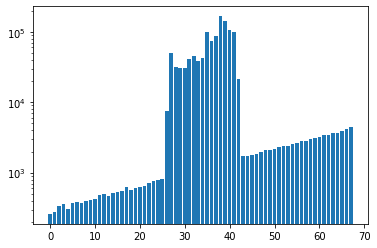

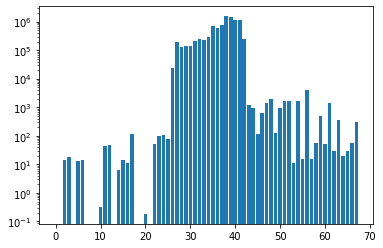

In [17]:
# Making sure we're consistent with what's on the server
def remove_dc_from_spad(noisy_spad, bin_edges, bin_weight, lam=1e-2, eps_rel=1e-5):
    """
    Works in numpy.
    :param noisy_spad: Length C array with the raw spad histogram to denoise.
    :param bin_edges: Length C+1 array with the bin widths in meters of the original bins.
    :param bin_weight: Length C nonnegative array controlling relative strength of L1 regularization on each bin.
    :param lam: float value controlling strength of overall L1 regularization on the signal
    :param eps: float value controlling precision of solver
    """
    assert len(noisy_spad.shape) == 1
    C = noisy_spad.shape[0]
    assert bin_edges.shape == (C+1,)
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    spad_equalized = noisy_spad / bin_widths
    x = cp.Variable((C,), "signal")
    z = cp.Variable((1,), "noise")
    obj = cp.Minimize(cp.sum_squares(spad_equalized - (x + z)) + lam * cp.sum(bin_weight*cp.abs(x)))
    constr = [
        x >= 0,
#         z >= 0
    ]
    prob = cp.Problem(obj, constr)
    prob.solve(solver=cp.OSQP, eps_rel=eps_rel)
    denoised_spad = np.clip(x.value * bin_widths, a_min=0., a_max=None)
    return denoised_spad


def preprocess_spad(spad_sid, sid_obj, correct_falloff, remove_dc, **dc_kwargs):
    if remove_dc:
        spad_sid = remove_dc_from_spad(spad_sid, sid_obj.sid_bin_edges, sid_obj.sid_bin_values[:-2]**2, **dc_kwargs)
    if correct_falloff:
        spad_sid = spad_sid * sid_obj.sid_bin_values[:-2]**2
    return spad_sid

# Make sure spad simulation is consistent
# from_server = intensities[0,0,...]
# local = (0.2989 * rgbs[..., 0, 0] + 0.5870 * rgbs[..., 1, 0] + 0.1140 * rgbs[..., 2, 0])/255.
# (from_server-local <= 1e-6).all() # OK
simulate_kwargs = {
        "spad_bins": 1024,
        "photon_count": 1e6,
        "dc_count": 1e5,
        "fwhm_ps": 70.,
        "use_poisson": True,
        "use_intensity": True,
        "use_squared_falloff": True,
        "use_jitter": True
} 
depth_truth = depths[..., 0]
intensity = intensities[0, 0, ...]
from_server = spads[0,:]
min_depth = 0.
max_depth=10.
# local = simulate_spad(depths[...,0], intensity, np.ones_like(depth), min_depth=0., max_depth=10., **simulate_kwargs)
# print(np.mean((from_server - local)/from_server))
# print(np.mean(from_server))
# np.mean(local)
spad_sid = rescale_bins(from_server, min_depth, max_depth, sid_obj=sid_obj)
print(spad_sid)
denoised_spad_sid = preprocess_spad(spad_sid, sid_obj,
                                    simulate_kwargs["use_squared_falloff"], 
                                    simulate_kwargs["dc_count"] > 0.,
                                    lam=1e1)
plt.figure()
plt.bar(range(len(spad_sid)), spad_sid, log=True)
plt.figure()
plt.bar(range(len(denoised_spad_sid)), denoised_spad_sid, log=True)

depth_init = inits[0, 0, ...]
pred, t = image_histogram_match(depth_init,
                                denoised_spad_sid,
                                weights=intensity,
                                sid_obj=sid_obj)
print(depth_truth.shape)
print(depth_init.shape)
print(pred.shape)
print("RMSE Before = {}".format(np.sqrt(np.mean((depth_init - depth_truth)**2))))
print("RMSE After = {}".format(np.sqrt(np.mean((depth_truth - pred)**2))))